In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.colors as mc
import datetime as dt
import matplotlib.colorbar as cbar
from scipy import stats
import cartopy.crs as ccrs
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
from dateutil import tz
import seaborn as sns
from pandas import DataFrame

/jobfs/87978050.gadi-pbs/ipykernel_400042/449447990.py:16: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

## Radar Rain Rate Data

In [3]:
# read in townsville radar rain rate data for 2 month period
mypathT = "/g/data/rq0/level_2/73/RAINRATE/"
files_T1 = [os.path.join(root, f) for root, _, files in os.walk(mypathT)
         for f in files
         if f.startswith('73_202201') and f.endswith('.nc')]
files_T2  = [os.path.join(root, f) for root, _, files in os.walk(mypathT)
         for f in files
         if f.startswith('73_202202') and f.endswith('.nc')]
files_T = files_T1+files_T2
# read cairns radar rain rate data for 2 month period
mypathC = "/g/data/rq0/level_2/19/RAINRATE/"
files_C1 = [os.path.join(root, f) for root, _, files in os.walk(mypathC)
         for f in files
         if f.startswith('19_202201') and f.endswith('.nc')]
files_C2  = [os.path.join(root, f) for root, _, files in os.walk(mypathC)
         for f in files
         if f.startswith('19_202202') and f.endswith('.nc')]
files_C = files_C1+files_C2
# read willis island reflectivity data for jan-feb 2022
mypathW = "/g/data/rq0/level_2/41/RAINRATE/"
files_W1 = [os.path.join(root, f) for root, _, files in os.walk(mypathW)
         for f in files
         if f.startswith('41_202201') and f.endswith('.nc')]
files_W2  = [os.path.join(root, f) for root, _, files in os.walk(mypathW)
         for f in files
         if f.startswith('41_202202') and f.endswith('.nc')]
files_W = files_W1+files_W2

ds_T = xr.open_mfdataset(files_T, engine="netcdf4")
ds_C = xr.open_mfdataset(files_C, engine="netcdf4")
ds_W = xr.open_mfdataset(files_W, engine="netcdf4")

In [7]:
ds_T.longitude.isel(x=150,time=0,y=150).values

array(146.5509, dtype=float32)

In [5]:
# open ds for bathymetry
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,150),y=slice(-22,-11))

In [6]:
# ds to plot topography
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))

lon, lat = np.meshgrid(lon, lat)
dem = ds_bath['z'].data

In [7]:
def plot_mean_rr(ds,x0,x1,regime_data,suptitle,title,level_data,cbar_ticks,cbar_units,bathym_lat,cmap,regime=None,bathymetry=None,
                          townsville=None,willis=None,contour_line_labels=None,bathym=None):    
     # Assign longitude values
    lon = ds.longitude.isel(y=150,time=0)
    # Assign (y) times
    time = np.arange(0,24,1)       
    # Assign (z) variable - mean rr data
    if regime==True:
        variable_data = regime_data
    else:
        variable_data = ds.rainrate.isel(y=150).groupby("time.hour").mean(dim=["time"],skipna=True)
    
    # create plot
    fig = plt.figure(figsize=(18,10))
    if bathymetry==True:
        ax1 = plt.subplot2grid((10, 10), (0, 0), 9, 9)
        ax2 = plt.subplot2grid((10, 10), (9, 0), 1, 9)
        ax3 = plt.subplot2grid((10, 10), (0, 9), 10, 1,frame_on=False)
    else:
        ax1 = fig.add_subplot()
    fig.patch.set_facecolor('white')
    ax1.set_xlim(x0,x1)
    
    # Set some titles
    ax1.set_title(title, loc='left', fontsize=20,fontweight=0.9)
    fig.figure.suptitle(suptitle,fontsize=30,x=0.45,y=0.96)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    levels = level_data
    cf = ax1.contourf(lon,time,variable_data,levels=levels,cmap=cmap)
    
    # plot contour lines & labels
    line_colors = ['black' for l in cf.levels]
    cs = ax1.contour(lon, time, variable_data, alpha=0.4,colors=line_colors, linewidths=0.8,linestyles='-')
    if contour_line_labels==True:
        plt.clabel(cs, fontsize=10,colors="white", inline=1,fmt = '%1.0f')
                    
    
    # plot vertical lines to represent radars
    if townsville==True:
        ax1.axvline(146.55,color='k',alpha=0.5,linestyle='-.')
    else: 
        ax1.axvline(145.68,color='k',alpha=0.5,linestyle='-.')
    
    # plot locations of radars
    if willis==True:
        ax1.axvline(149.96,color='k',alpha=0.5,linestyle='-.')
    
    if bathym==True:
        sel_lat = ds_bath.sel(y=bathym_lat,method="nearest").sel(x=slice(x0,x1))
        ax2.plot(sel_lat["x"],sel_lat["z"])
        ax2.set_xlim(x0,x1)
        ax2.set_ylim(0,1000)
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right') 
        ax2.locator_params(axis='y', nbins=4)
        ax2.set_ylabel("Height (m)")
        ax2.set_xlabel("Longitude",fontsize=20)
        # cbar and cbar label              
        cbar = plt.colorbar(cf, ax=ax3,orientation='vertical', location="right", pad=0.04, aspect=40, extendrect=True,
                         ticks=cbar_ticks)
        cbar.set_label(cbar_units,fontsize=20)
        ax3.set_yticks([])
        ax3.set_xticks([])
        ax1.set_xticklabels([])

    else:    
        # cbar and cbar label              
        cbar = plt.colorbar(cf, ax=ax1,orientation='vertical', location="right", pad=0.04, aspect=40, extendrect=True,
                         ticks=cbar_ticks)
        cbar.set_label(cbar_units,fontsize=15)
        ax1.set_xlabel("Longitude",fontsize=20)
        
    # plot horizontal gridlines
    ax1.grid(visible=None, which='major', axis='y',alpha=0.25)
    # y-ticks & labels
    ax1.set_yticks(np.arange(0,24,1))
    ax1.set_yticklabels(["10","11","12","13","14","15","16","17","18","19","20","21","22","23",
                           "00","01","02","03","04","05","06","07","08","09"])
    ax1.locator_params(axis='y', nbins=4)
    ax1.set_ylabel("AEST Hour",fontsize=20)            
    plt.show()
    return

### make sure below is using right dataset

In [54]:
# create easterly and westerly data
Tjan = ds_T.rainrate.isel(y=150).sel(time=ds_T.time.dt.month.isin([1]))
Tjan_west = Tjan.sel(time=Tjan.time.dt.day.isin([1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,23,24,25]))#,26,27,28,31]))
Tjan_east = Tjan.sel(time=Tjan.time.dt.day.isin([10,11,12,20,21,22,29,30]))

Tfeb = ds_T.rainrate.isel(y=150).sel(time=ds_T.time.dt.month.isin([2]))
Tfeb_west = Tfeb.sel(time=Tfeb.time.dt.day.isin([]))#1,2,3,4,9,10,11,12,23,24,25,26,27,28]))
Tfeb_east = Tfeb.sel(time=Tfeb.time.dt.day.isin([5,6,7,8,13,14,15,16,17,18,19,20,21,22,]))

# combine each month westerly and easterly data
Twest = xr.concat([Tjan_west,Tfeb_west],dim="time")
Teast = xr.concat([Tjan_east,Tfeb_east],dim="time")
# find mean rr by grouping
#westerlies = Twest.groupby("time.hour").mean(dim=["time"],skipna=True)
#easterlies = Teast.groupby("time.hour").mean(dim=["time"],skipna=True)

# find frequency of data points
west = Twest.fillna(0)
east = Teast.fillna(0)
westerlies = Twest.groupby("time.hour").count()
easterlies = Teast.groupby("time.hour").count()

# plot frequency of value plots

In [43]:
# testing values: ds_T.latitude.isel(time=0,y=150,x=150).values
# Townsville (lat=-19.4198) -19.41 [145.12054,147.9812]
# Cairns (lat=-16.82) [144.27374,147.09222], 
# Willis Island (lat=-16.29) [148.55927,151.36993]

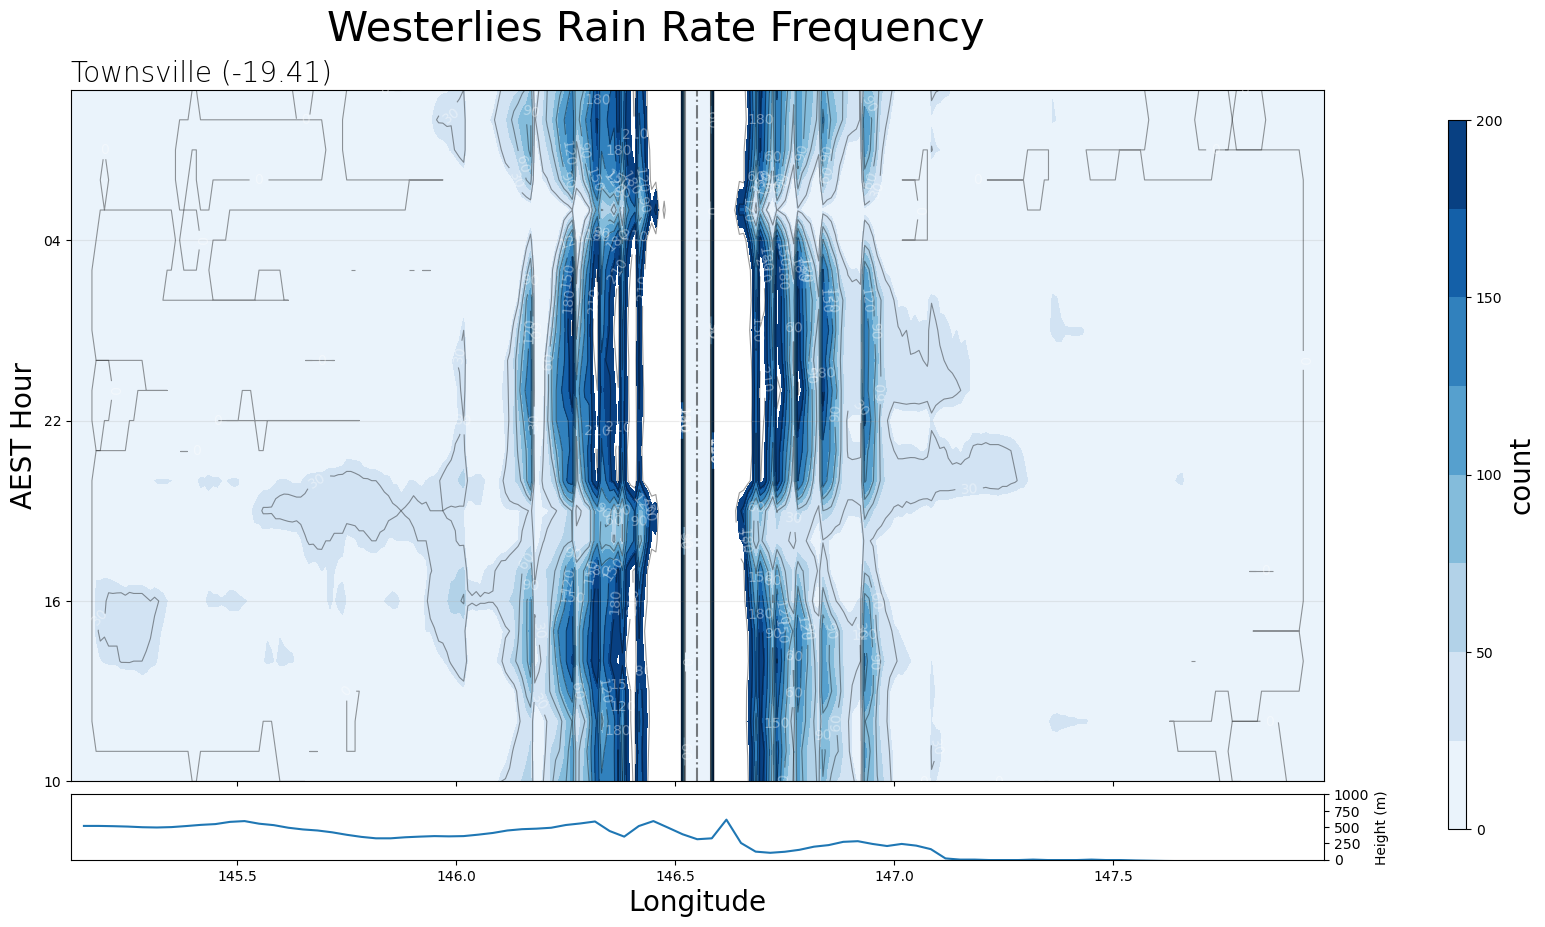

In [55]:
plot_mean_rr(ds_T,145.12054,147.9812,westerlies,"Westerlies Rain Rate Frequency","Townsville (-19.41)",
             [0,25,50,75,100,125,150,175,200],
             [0,50,100,150,200],"count",-19.41,"Blues",regime=True,bathymetry=True,
             townsville=True,willis=False,contour_line_labels=True,bathym=True) 

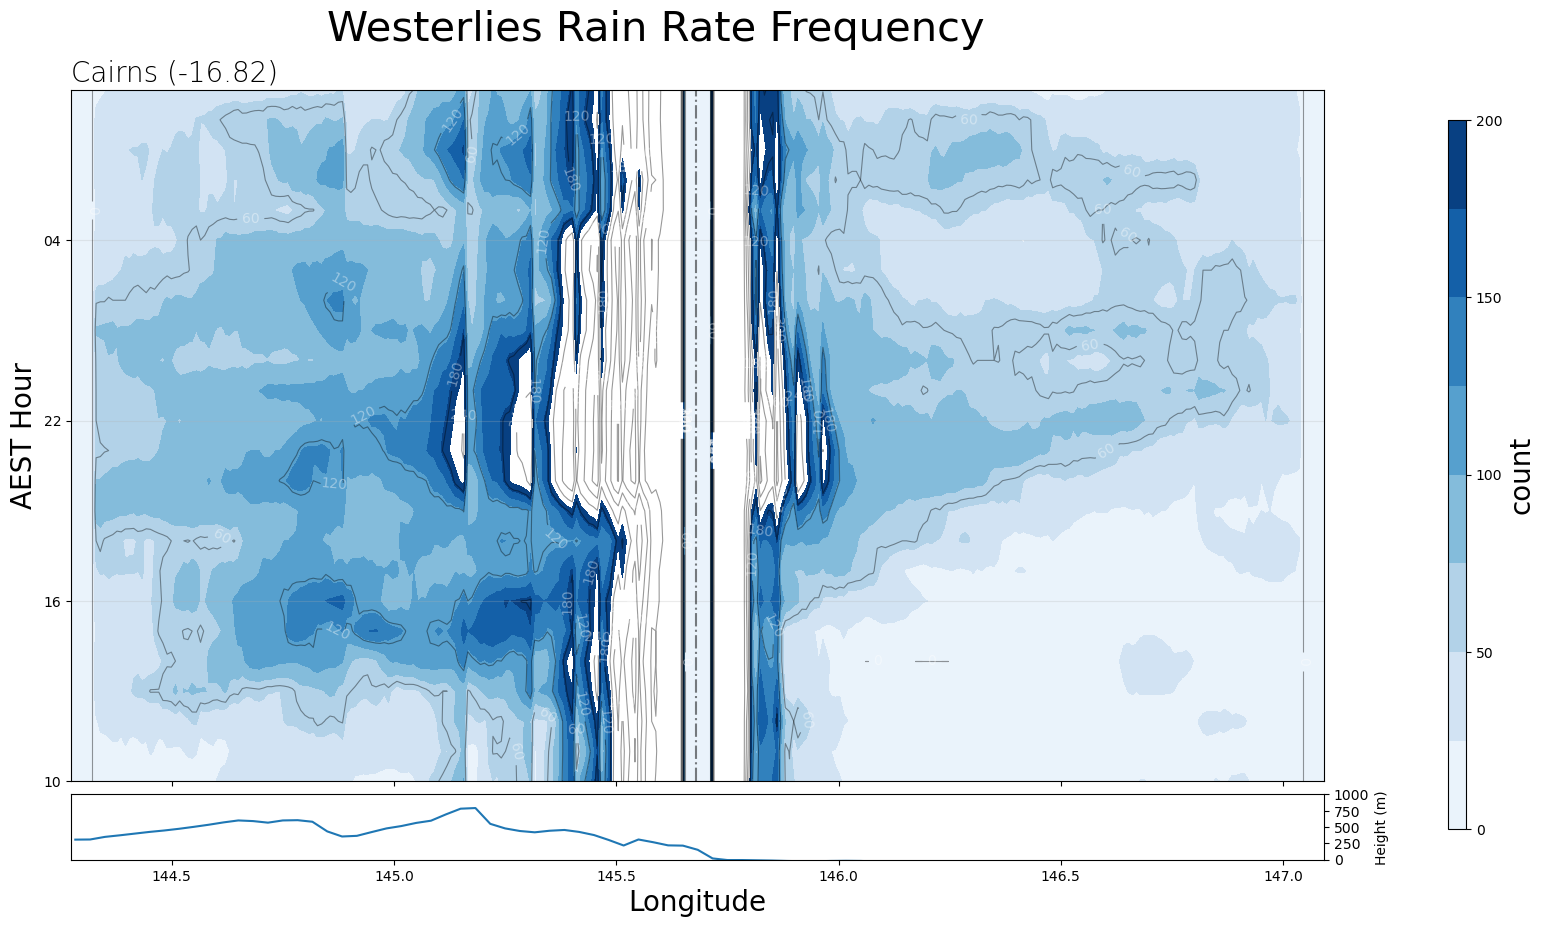

In [21]:
plot_mean_rr(ds_C,144.27374,147.09222,westerlies,"Westerlies Rain Rate Frequency","Cairns (-16.82)",
             [0,25,50,75,100,125,150,175,200],
             [0,50,100,150,200],"count",-16.82,"Blues",regime=True,bathymetry=True,
             townsville=False,willis=False,contour_line_labels=True,bathym=True) 

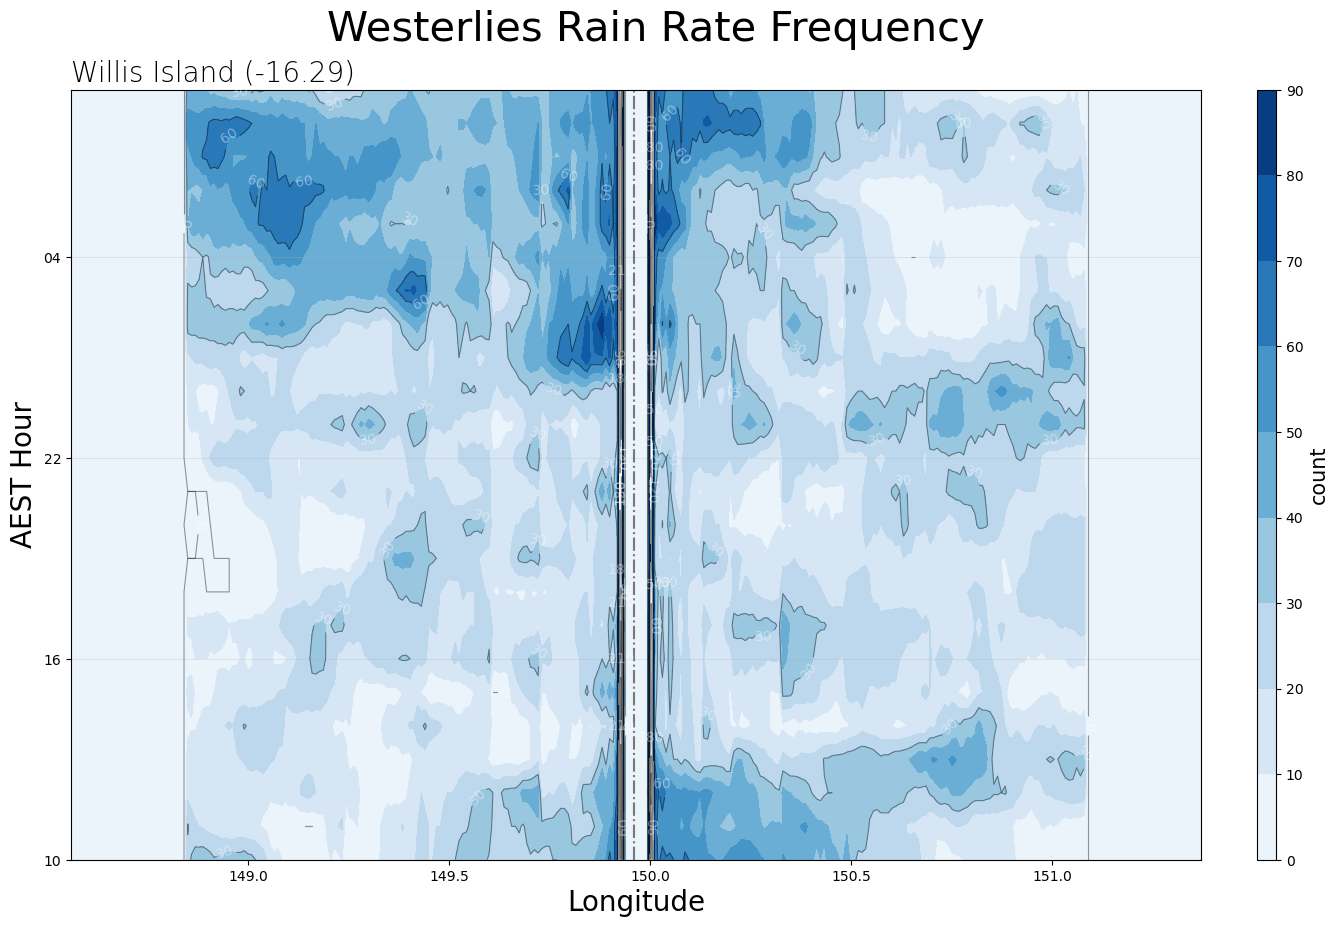

In [140]:
plot_mean_rr(ds_W,148.55927,151.36993,westerlies,"Westerlies Rain Rate Frequency","Willis Island (-16.29)",
             [0,10,20,30,40,50,60,70,80,90],[0,10,20,30,40,50,60,70,80,90],"count",-16.29,"Blues",regime=True,bathymetry=False,
             townsville=False,willis=True,contour_line_labels=True,bathym=False) 

# easterlies

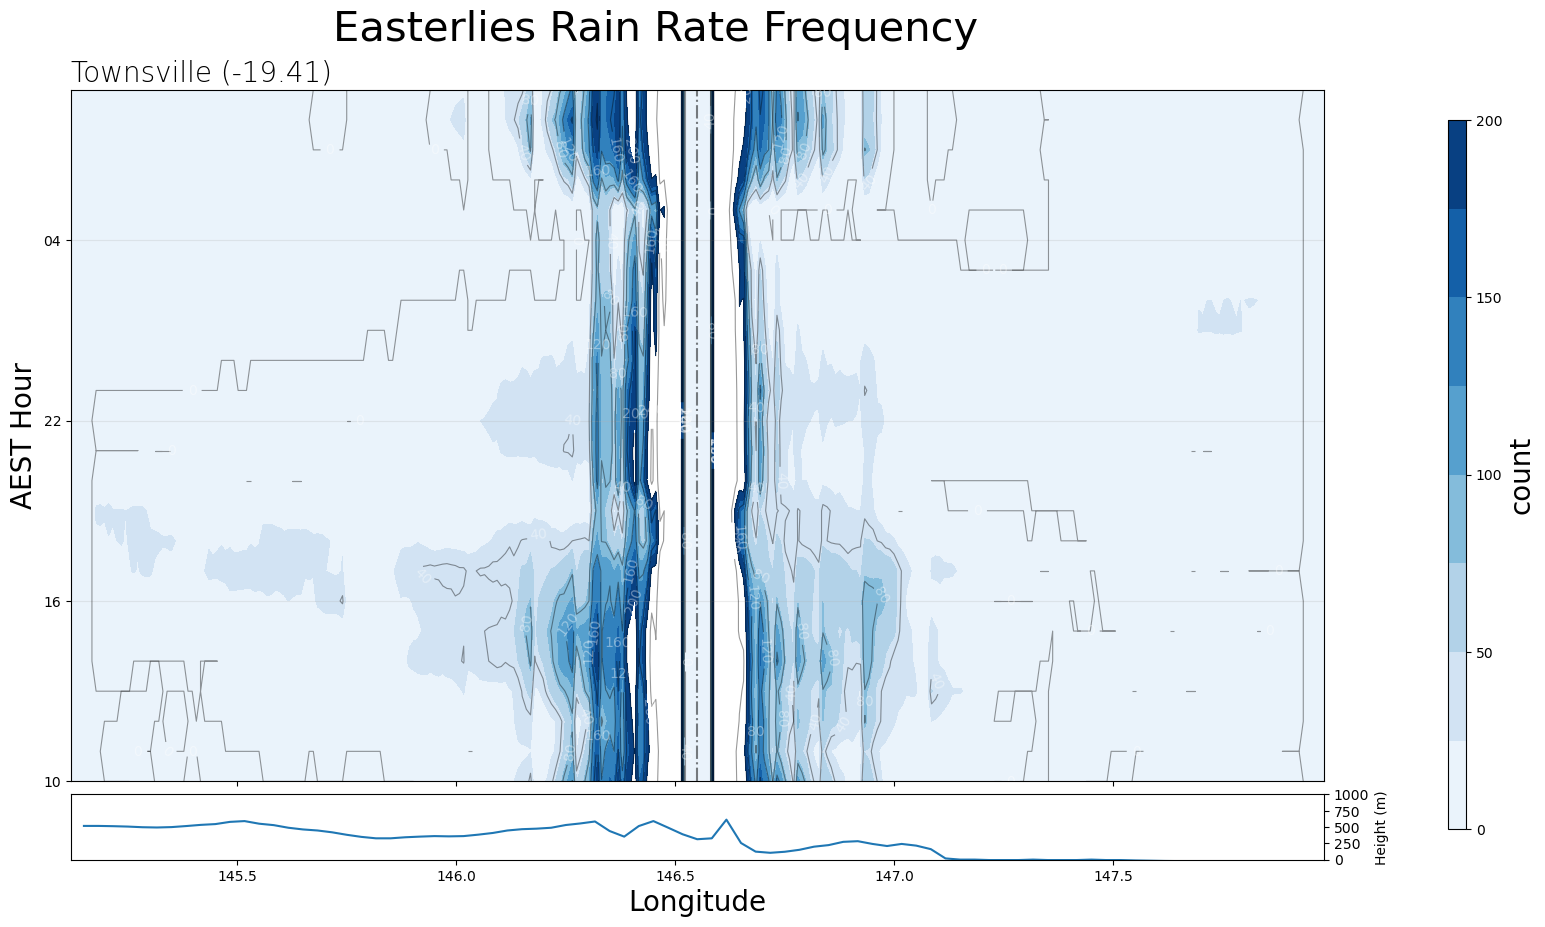

In [19]:
plot_mean_rr(ds_T,145.12054,147.9812,easterlies,"Easterlies Rain Rate Frequency","Townsville (-19.41)",
             [0,25,50,75,100,125,150,175,200],
             [0,50,100,150,200],"count",-19.41,"Blues",regime=True,bathymetry=True,
             townsville=True,willis=False,contour_line_labels=True,bathym=True)

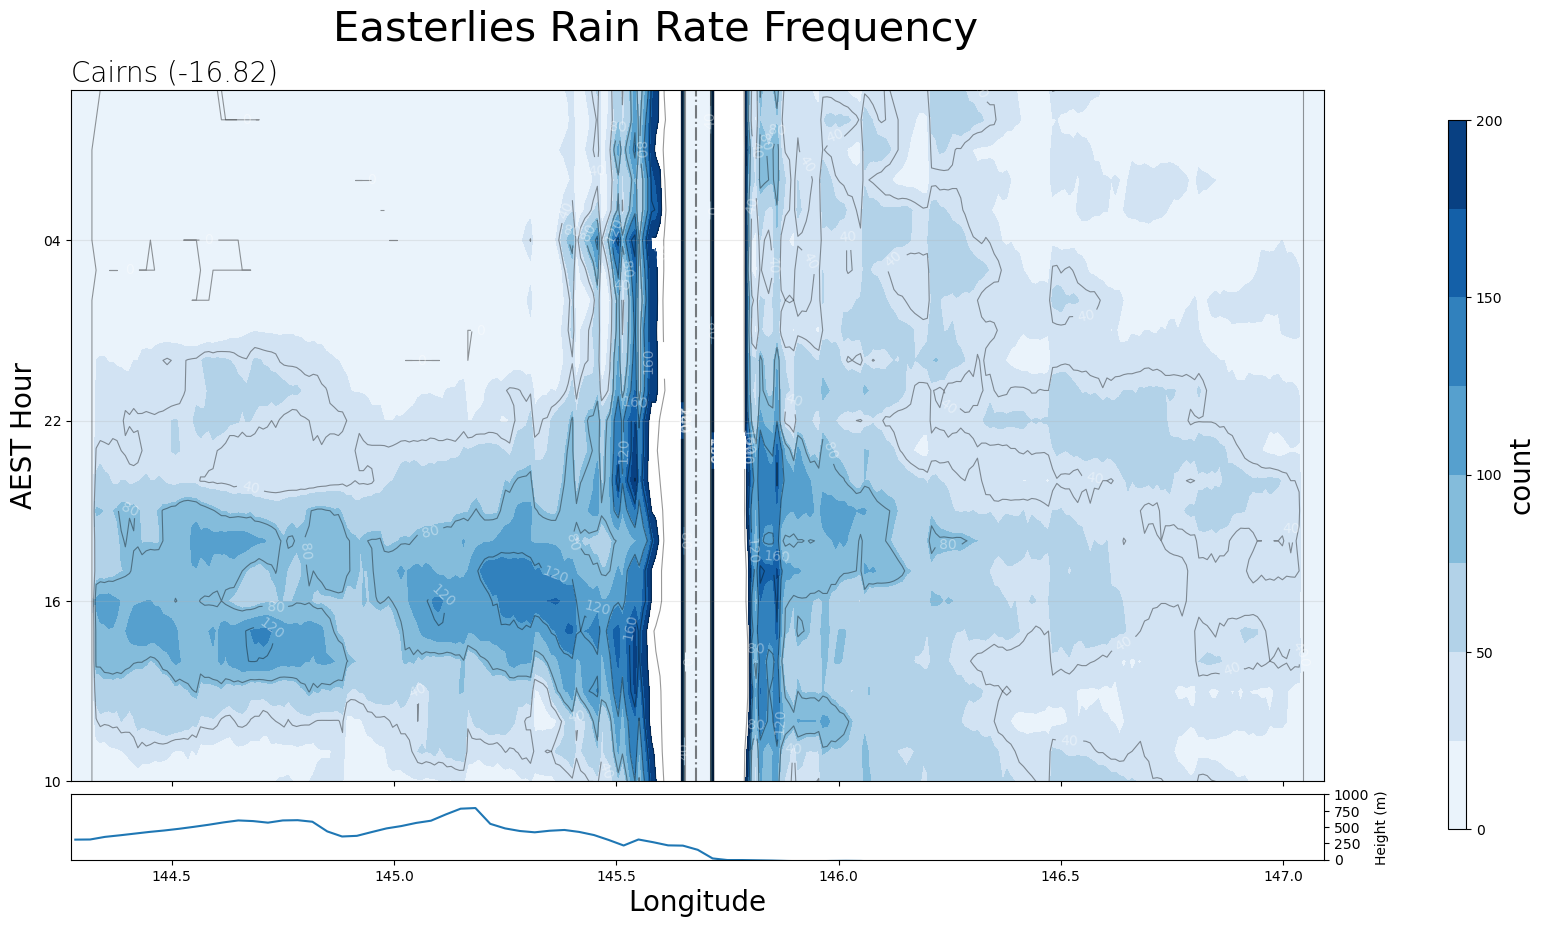

In [22]:
plot_mean_rr(ds_C,144.27374,147.09222,easterlies,"Easterlies Rain Rate Frequency","Cairns (-16.82)",
             [0,25,50,75,100,125,150,175,200],
             [0,50,100,150,200],"count",-16.82,"Blues",regime=True,bathymetry=True,
             townsville=False,willis=False,contour_line_labels=True,bathym=True) 

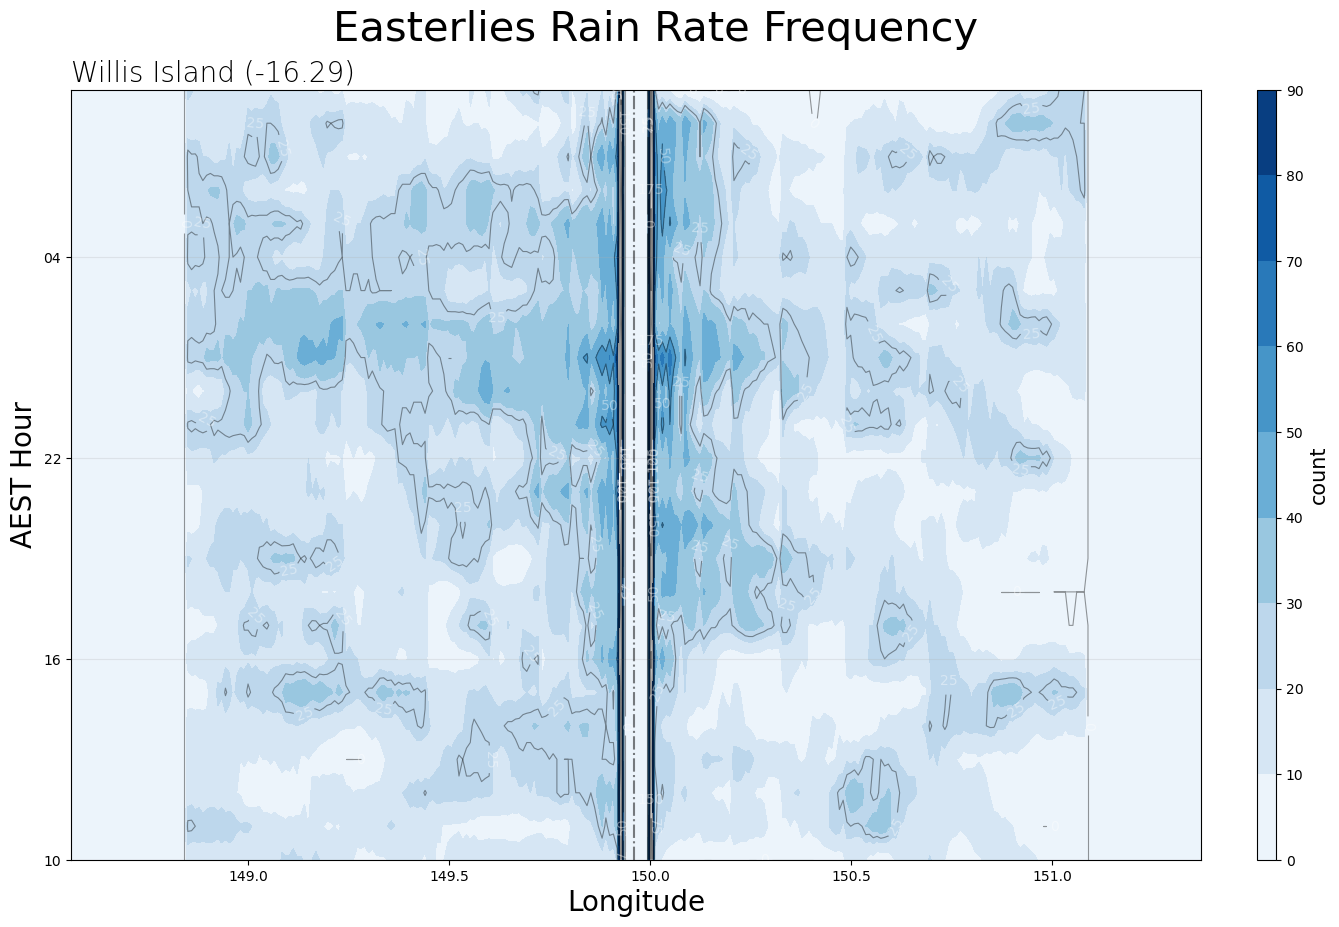

In [141]:
plot_mean_rr(ds_W,148.55927,151.36993,easterlies,"Easterlies Rain Rate Frequency","Willis Island (-16.29)",
             [0,10,20,30,40,50,60,70,80,90],[0,10,20,30,40,50,60,70,80,90],"count",-16.29,"Blues",regime=True,bathymetry=False,
             townsville=False,willis=True,contour_line_labels=True,bathym=False) 

# plot mean rain rate plots

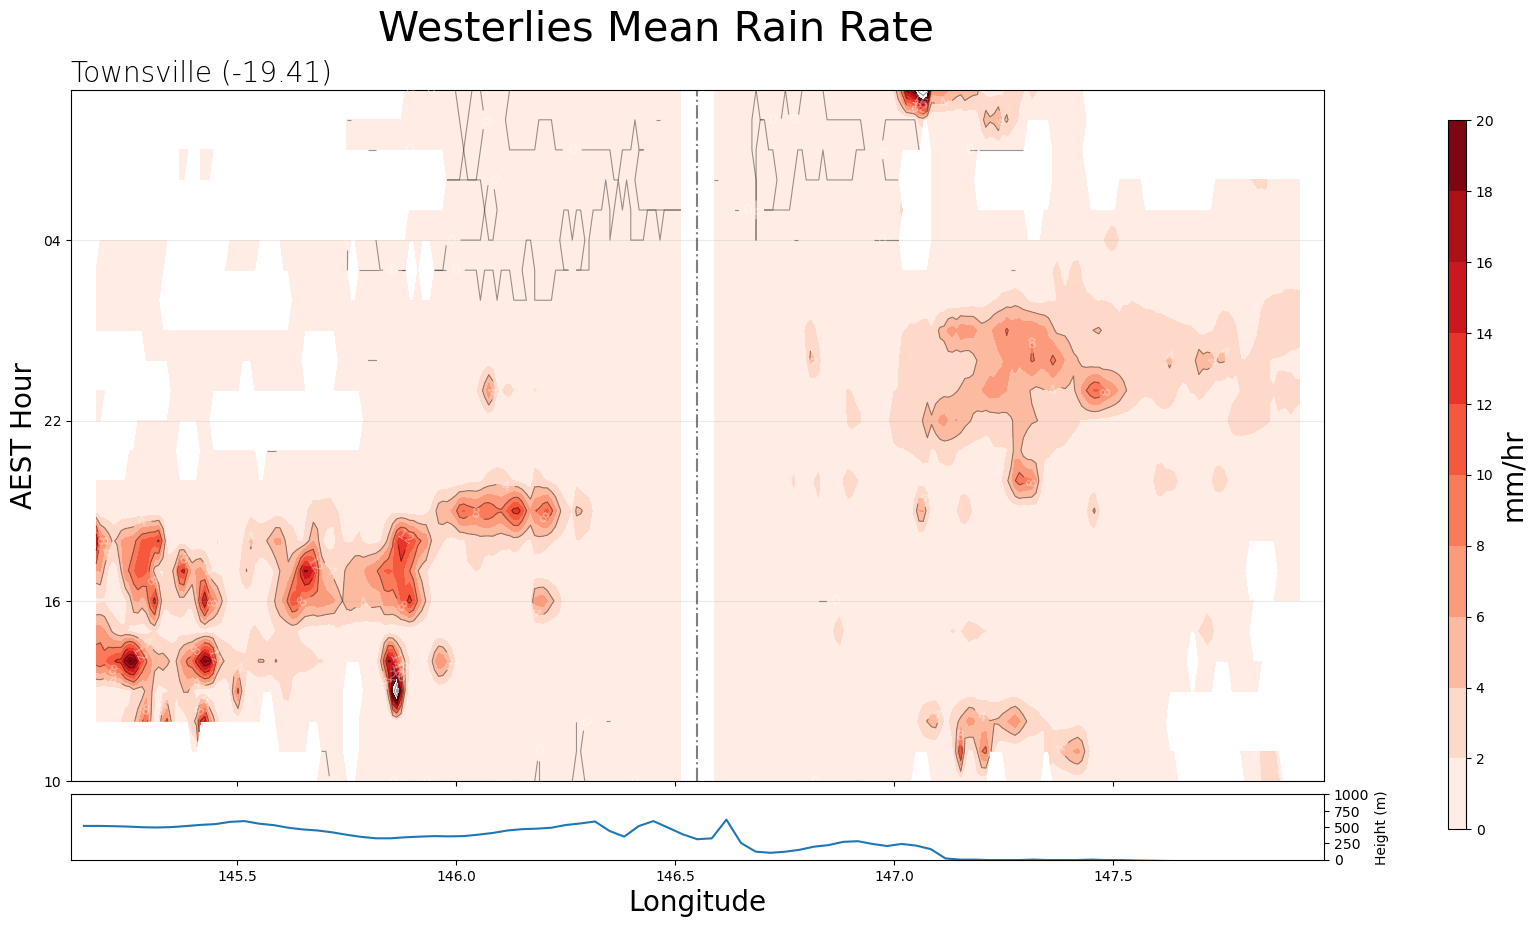

In [53]:
plot_mean_rr(ds_T,145.12054,147.9812,westerlies,"Westerlies Mean Rain Rate","Townsville (-19.41)",
             [0,2,4,6,8,10,12,14,16,18,20],[0,2,4,6,8,10,12,14,16,18,20],"mm/hr",-19.41,"Reds",regime=True,bathymetry=True,
             townsville=True,willis=False,contour_line_labels=True,bathym=True) 

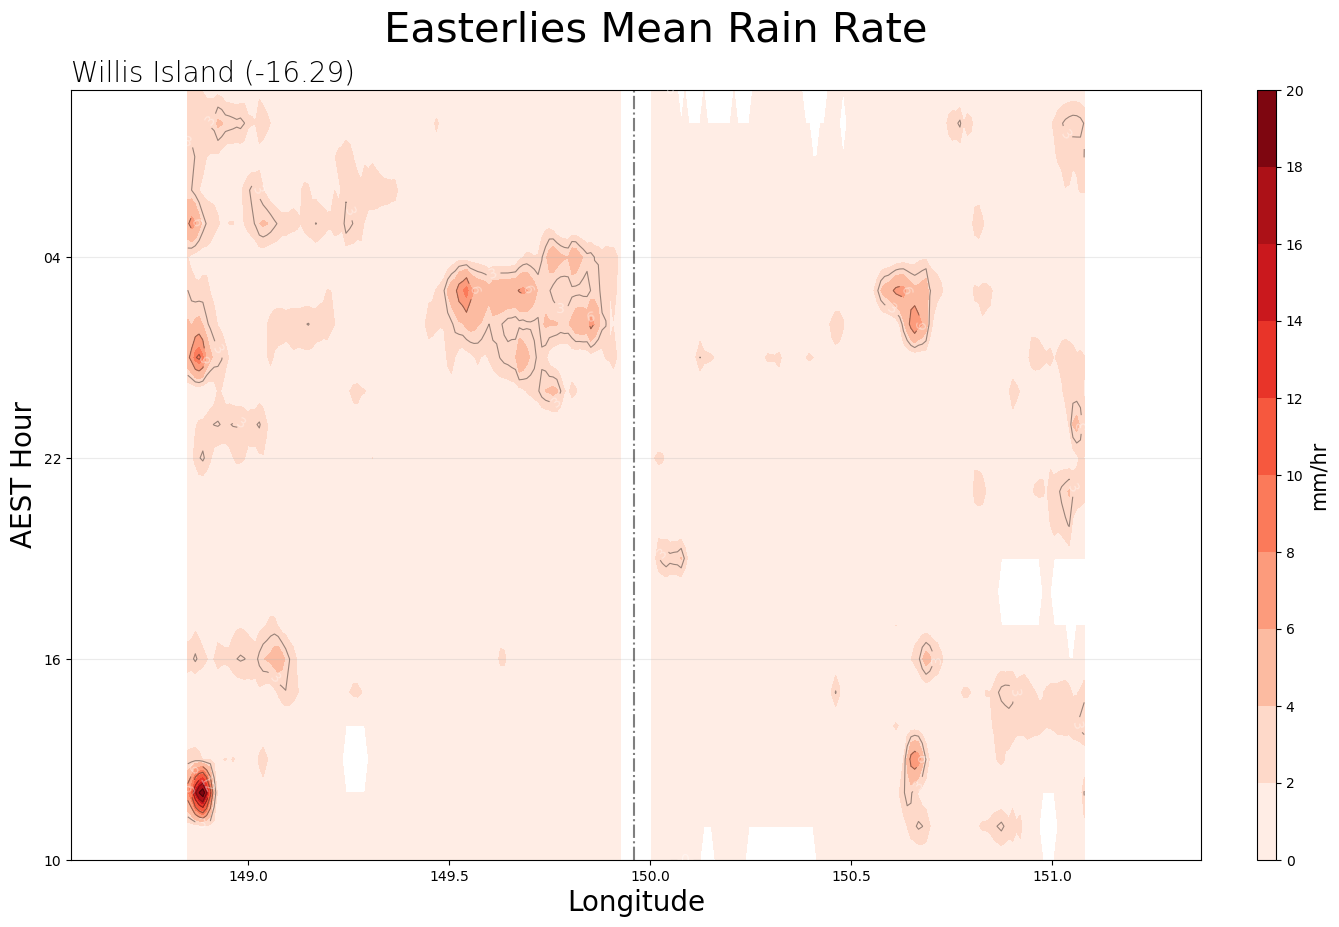

In [387]:
plot_mean_rr(ds_W,148.55927,151.36993,easterlies,"Easterlies Mean Rain Rate","Willis Island (-16.29)",
             [0,2,4,6,8,10,12,14,16,18,20],"mm/hr",-16.29,"Reds",regime=True,bathymetry=False,
             townsville=False,willis=True,contour_line_labels=True,bathym=False) 

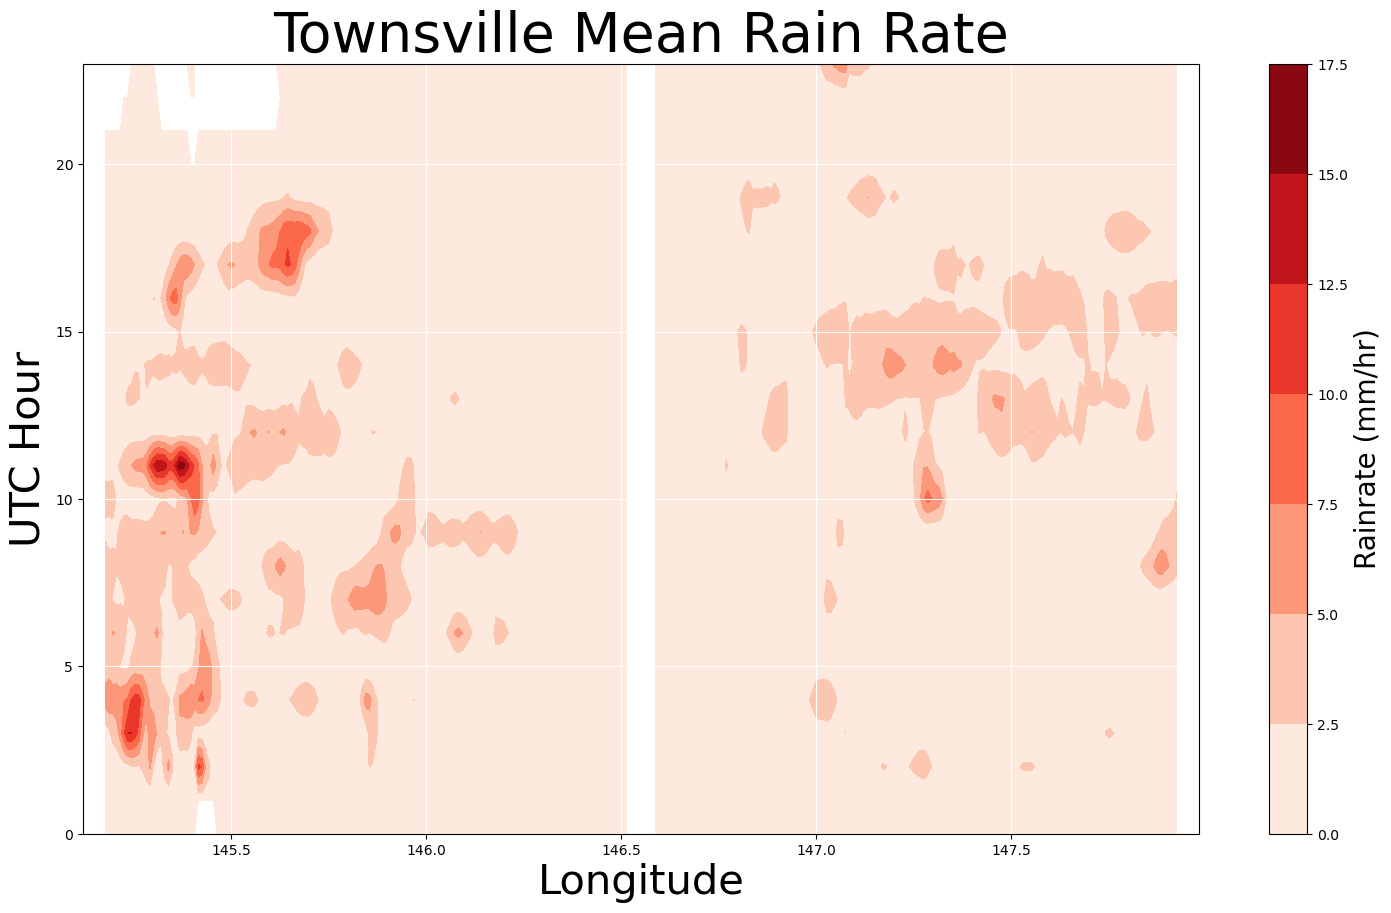

In [153]:
# variables to plot
dataT = ds_T.rainrate.isel(y=150).groupby("time.hour").mean(dim=["time"],skipna=True)
long = ds_T.longitude.isel(y=150,time=0)
time = np.arange(0,24,1)

# plot
fig = plt.figure(1, figsize=[18,10])
fig.tight_layout()
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1)
ax.set_title("Townsville Mean Rain Rate",loc="center",fontsize=40)
cf = plt.contourf(long,time,dataT,cmap="Reds")
cbar = plt.colorbar(cf,aspect=20,orientation='vertical',ax=ax)
cbar.set_label('Rainrate (mm/hr)',fontsize=20) 
ax.grid(True,color="white")
ax.set_xlabel("Longitude",fontsize=30)
ax.set_ylabel("UTC Hour",fontsize=30);

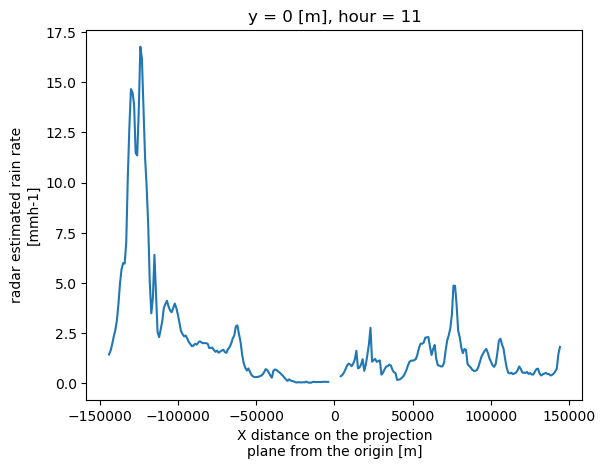

In [125]:
dataT.isel(hour=11).plot()

In [42]:
# define function to separate rr into each hour
def hourly_files(df,hour):
    hourly_data = []
    for i in df.time:
        rainrate = df.rainrate.sel(time=i,y=0)        
        times = np.datetime_as_string(i, unit='s')
        if times[11:13]==hour:
            hourly_data.append(rainrate)
    return hourly_data

In [43]:
# hour_data = ["utc00","utc01","utc02","utc03","utc04","utc05","utc06","utc07","utc08","utc09","utc10","utc11",
#                   "utc12","utc13","utc14","utc15","utc16","utc17","utc18","utc19","utc20","utc21","utc22","utc23"]
def get_hourly_data(ds):
    hours = ["00","01","02","03","04","05","06","07","08","09","10","11","12","13",
             "14","15","16","17","18","19","20","21","22","23"]
    data = []
    for i in enumerate(hours):
        print(i[1])
        datah = hourly_files(ds,i[1])
        data.append(datah)
    return data

In [44]:
dsT = get_hourly_data(ds_T)

00
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
np.shape(dsT)
#ds[0]

In [ ]:
dsT

In [11]:
utc00 = hourly_files(ds_T,"00")
utc01 = hourly_files(ds_T,"01")
utc02 = hourly_files(ds_T,"02")
utc03 = hourly_files(ds_T,"03")
utc04 = hourly_files(ds_T,"04")
utc05 = hourly_files(ds_T,"05")
print("5")
utc06 = hourly_files(ds_T,"06")
utc07 = hourly_files(ds_T,"07")
utc08 = hourly_files(ds_T,"08")
utc09 = hourly_files(ds_T,"09")
utc10 = hourly_files(ds_T,"10")
print("10")
utc11 = hourly_files(ds_T,"11")
utc12 = hourly_files(ds_T,"12")
utc13 = hourly_files(ds_T,"13")
utc14 = hourly_files(ds_T,"14")
utc15 = hourly_files(ds_T,"15")
print("15")
utc16 = hourly_files(ds_T,"16")
utc17 = hourly_files(ds_T,"17")
utc18 = hourly_files(ds_T,"18")
utc19 = hourly_files(ds_T,"19")
utc20 = hourly_files(ds_T,"20")
print("20")
utc21 = hourly_files(ds_T,"21")
utc22 = hourly_files(ds_T,"22")
utc23 = hourly_files(ds_T,"23")

5
10
15
20


In [12]:
# define function to find mean rr for each longitude over all hours in file
def mean_rr(rrdata):
    # convert list file to array in order to do calculations
    array = np.array(rrdata)
    array[np.isnan(array)] = 0   ########################## nan to zero - skews non-valued locations to zero
    # axis (column) to calculate mean over
    mean = array.mean(axis=0)
    return mean

In [13]:
meanutc00 = mean_rr(utc00)
meanutc01 = mean_rr(utc01)
meanutc02 = mean_rr(utc02)
meanutc03 = mean_rr(utc03)
meanutc04 = mean_rr(utc04)
meanutc05 = mean_rr(utc05)
print("5")
meanutc06 = mean_rr(utc06)
meanutc07 = mean_rr(utc07)
meanutc08 = mean_rr(utc08)
meanutc09 = mean_rr(utc09)
meanutc10 = mean_rr(utc10)
print("10")
meanutc11 = mean_rr(utc11)
meanutc12 = mean_rr(utc12)
meanutc13 = mean_rr(utc13)
meanutc14 = mean_rr(utc14)
meanutc15 = mean_rr(utc15)
print("15")
meanutc16 = mean_rr(utc16)
meanutc17 = mean_rr(utc17)
meanutc18 = mean_rr(utc18)
meanutc19 = mean_rr(utc19)
meanutc20 = mean_rr(utc20)
print("20")
meanutc21 = mean_rr(utc21)
meanutc22 = mean_rr(utc22)
meanutc23 = mean_rr(utc23)

5
10
15
20


In [24]:
print(np.shape(meanutc00))
mean_4_each_hour = [meanutc00, meanutc01, meanutc02, meanutc03, meanutc04, meanutc05, meanutc06,meanutc07,meanutc08,
                    meanutc09,meanutc10,meanutc11,meanutc12,meanutc13,meanutc14,meanutc15,meanutc16,meanutc17,meanutc18,
                    meanutc19,meanutc20,meanutc21,meanutc22,meanutc23]
radar_mean_rr = []
for i in mean_4_each_hour:
    radar_mean_rr.append(i)    
np.shape(radar_mean_rr)

(301,)


(24, 301)

In [27]:
def radar_field(xbin1,ybin1,values1,cmap,units,title): #,save):#,title1):
    sns.set_style("whitegrid")
    
    fig = plt.figure(1, figsize=[18,10])
    fig.tight_layout()
    ax = plt.subplot(1,1,1)
    ax.set_title(title,loc="center",fontsize=40)#,weight="bold")
    
    # z = 2.5 km
    cs1 = ax.contourf(xbin1,ybin1,values1,cmap=cmap,vmin=0,vmax=1) #vmin vmax set cbar range
    ax.grid(True,color="white")

    ax.set_xlabel('Longitude',fontsize=30)
    ax.set_ylabel('UTC hour',fontsize=30)
    
    ax.set_xticks(np.arange(0,300,1))
    ax.locator_params(axis='x', nbins=4)
    ax.set_yticks(np.arange(0,24,1))
    ax.set_yticklabels(["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14",
                           "15","16","17","18","19","20","21","22","23"])
    ax.locator_params(axis='y', nbins=4)
    
    ax.set_facecolor('darkgrey')
    cbar = plt.colorbar(cs1,aspect=20,orientation='vertical',ax=ax)
    cbar.set_label('Rainrate'+" (%s)"%(units),fontsize=20) 
    return

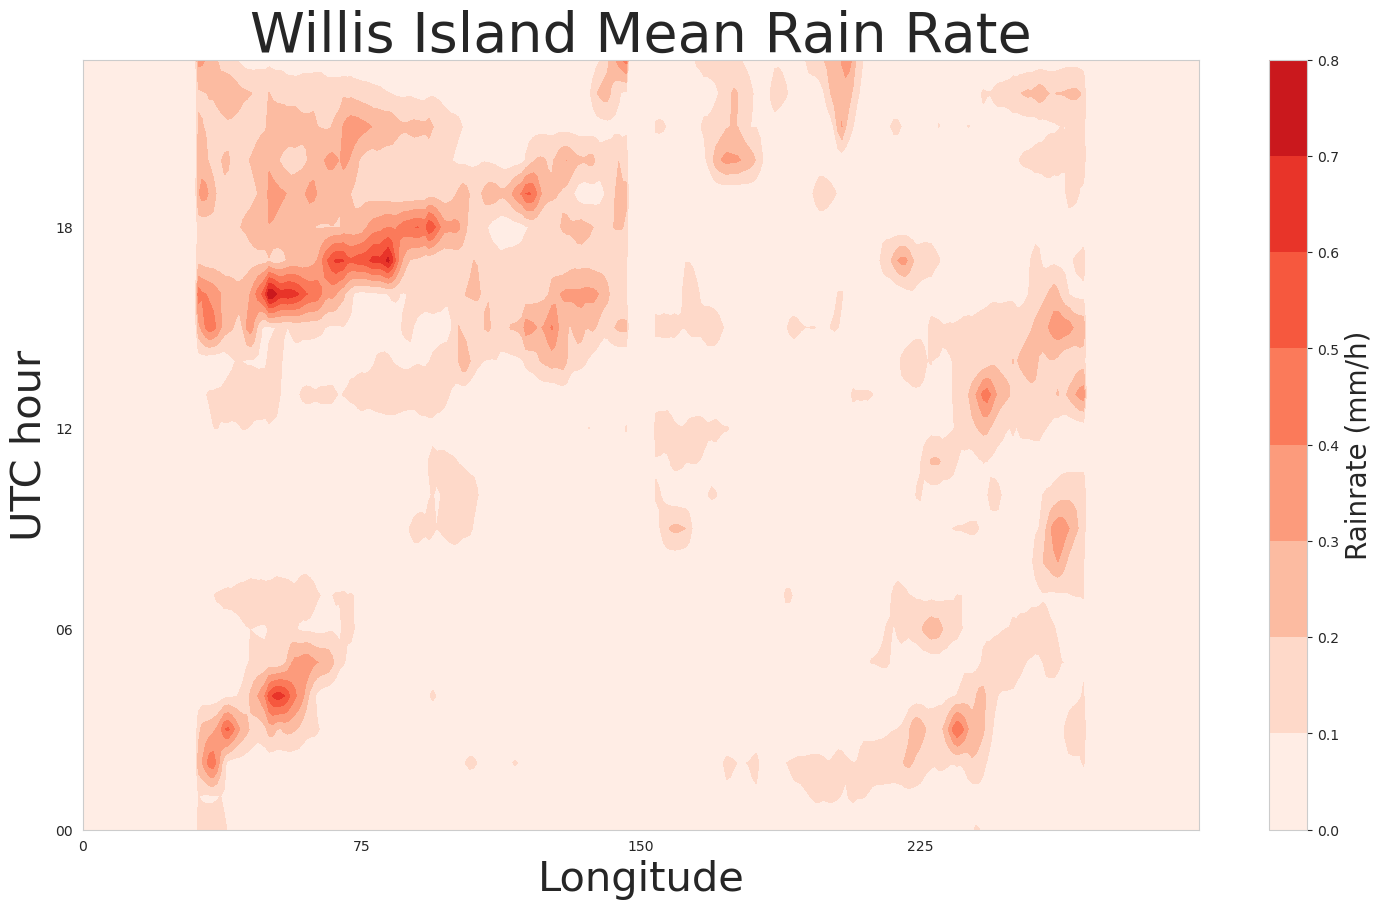

In [28]:
radar_field(np.arange(0,301,1),np.arange(0,24,1),radar_mean_rr,"Reds","mm/h","Willis Island Mean Rain Rate")

<xarray.DataArray 'rainrate' (y: 301, x: 301)>
dask.array<getitem, shape=(301, 301), dtype=float32, chunksize=(301, 301), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 -150000 -149000 -148000 -147000 ... 148000 149000 150000
  * y        (y) int32 -150000 -149000 -148000 -147000 ... 148000 149000 150000
    time     datetime64[ns] 2022-01-01
Attributes:
    long_name:    radar estimated rain rate
    units:        mmh-1
    description:  Rainfall retrieval using a:355.5 b:1.19 for the lowest leve...
    comments:     cutoff of 55.0dBZ applied before rainfall calculation
    valid_min:    0
    valid_max:    300.80568938346005

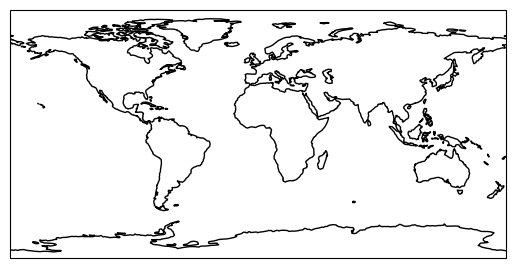

In [8]:
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
# data
import geopandas
#gdf = geopandas.GeoDataFrame(ds_T.rainrate.isel(time=0), geometry=geopandas.points_from_xy(ds_T.longitude.isel(time=0), ds_T.latitude.isel(time=0)))
#print(gdf.head)
from shapely import LineString
line = ([],[])

#ax.set_xlim([144,148])
#ax.set_xticks([144,145,146,147,148])
#ax.set_xticklabels([144,145,146,147,148])
#ax.set_ylim([-19,-15])
#ax.set_yticks([-19,-18,-17,-16,-15])
#ax.set_yticklabels([-19,-18,-17,-16,-15])
#plt.colorbar(cs1,aspect=20,orientation='vertical',ax=ax)


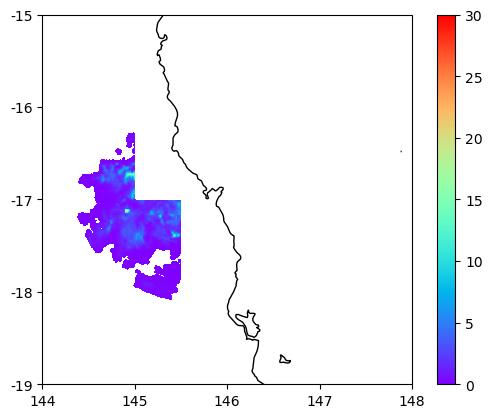

In [74]:
#T_data = (ds_T.rainrate.isel(time=500).sel(y=slice(-14,-17)).sel(x=slice(140,145)))# and (ds_T.rainrate.isel(time=500).sel(y=slice(-17,-30)).sel(x=slice(140,145.5)))
#T_data
#T = (ds_T.rainrate.isel(time=500).isel(y=slice(0,150),x=slice(0,120))) + (ds_T.rainrate.isel(time=500).isel(y=slice(0,151),x=slice(0,130)))

mask_C0 = ds_C.rainrate.where((ds_C.longitude<145)&(ds_C.latitude>-17)).isel(time=500)
mask_C1 = ds_C.rainrate.where((ds_C.longitude<145.5)&(ds_C.latitude<=-17)).isel(time=500)
mask_C = ds_C.rainrate.where(((ds_C.longitude<145)&(ds_C.latitude>-17))+((ds_C.longitude<145.5)&(ds_C.latitude<=-17))).isel(time=500)
mask_C

#mask_T.plot()
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
cs1 = ax.pcolormesh(ds_C.longitude.isel(time=0),ds_C.latitude.isel(time=0),mask_C,cmap="rainbow",vmin=0,vmax=30)
ax.set_xlim([144,148])
ax.set_xticks([144,145,146,147,148])
ax.set_xticklabels([144,145,146,147,148])
ax.set_ylim([-19,-15])
ax.set_yticks([-19,-18,-17,-16,-15])
ax.set_yticklabels([-19,-18,-17,-16,-15])
plt.colorbar(cs1,aspect=20,orientation='vertical',ax=ax)

In [76]:
# 
#rr_T = ds_T.rainrate.isel(y=150,x=slice(0,150)).values

def radar_field(xbin1,xbin2,xbin3,ybin1,ybin2,ybin3,values1,values2,values3,cmap,units,title): #,save):#,title1):
    sns.set_style("whitegrid")
    
    fig = plt.figure(1, figsize=[25,13])
    fig.tight_layout()
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(title,loc="center",fontsize=40)#,weight="bold")
    
    # z = 2.5 km
    cs1 = ax.pcolormesh(xbin1,ybin1,values1,cmap=cmap,vmin=0,vmax=40) #vmin vmax set cbar range
    cs2 = ax.pcolormesh(xbin2,ybin2,values2,cmap=cmap,vmin=0,vmax=40)
    cs3 = ax.pcolormesh(xbin3,ybin3,values3,cmap=cmap,vmin=0,vmax=40)
    
    ax.grid(True,color="white")
    circle_T_center = mpatches.Circle((146.5509,-19.4198),0.05,alpha=1,fc="black") # Townsville 
    circle_C_center = mpatches.Circle((145.683,-16.817),0.05,alpha=1,fc="black") # Cairns 
    circle_W_center = mpatches.Circle((149.9646,-16.2874),0.05,alpha=1,fc="black") # Willis Island 
    ax.add_patch(circle_T_center)
    ax.add_patch(circle_C_center)
    ax.add_patch(circle_W_center)
    
    # radar field coverage
    circle_T = mpatches.Circle((146.5509,-19.4198),1.358,alpha=0.2,fc="grey") # Townsville
    circle_C = mpatches.Circle((145.683,-16.817),1.358,alpha=0.2,fc="grey") # Cairns
    circle_W = mpatches.Circle((149.9646,-16.2874),1.358,alpha=0.2,fc="grey") # Willis Island
    ax.add_patch(circle_T)
    ax.add_patch(circle_C)
    ax.add_patch(circle_W)
    
    # radar station name annotations
    ax.annotate("Townsville",(145.75,-19.3),fontsize=18)
    ax.annotate("Cairns",(145.1,-17.1),fontsize=18)
    ax.annotate("Willis Island",(148.8,-16.2),fontsize=18)

    ax.set_xlabel('Longitude',fontsize=30)
    ax.set_ylabel('Latitude',fontsize=30)
    
    ax.set_xticks([142,143,144,145,146,147,148,149,150,151,152])
    ax.set_xticklabels([142,143,144,145,146,147,148,149,150,151,152])
    ax.set_yticks([-21,-20,-19,-18,-17,-16,-15])
    ax.set_yticklabels([-21,-20,-19,-18,-17,-16,-15])
    
    ax.set_xlim([142,152])
    ax.set_ylim([-21,-15])
    
    ax.set_facecolor('darkgrey')
    cbar = plt.colorbar(cs1,aspect=20,orientation='vertical',ax=ax)#,ticks=[-5,0,10,20,30,40,50])
    cbar.set_label('Rainrate'+" (%s)"%(units),fontsize=20) 
    #plt.show()
    #plt.savefig(indir+'%s.png'%(save))
    return

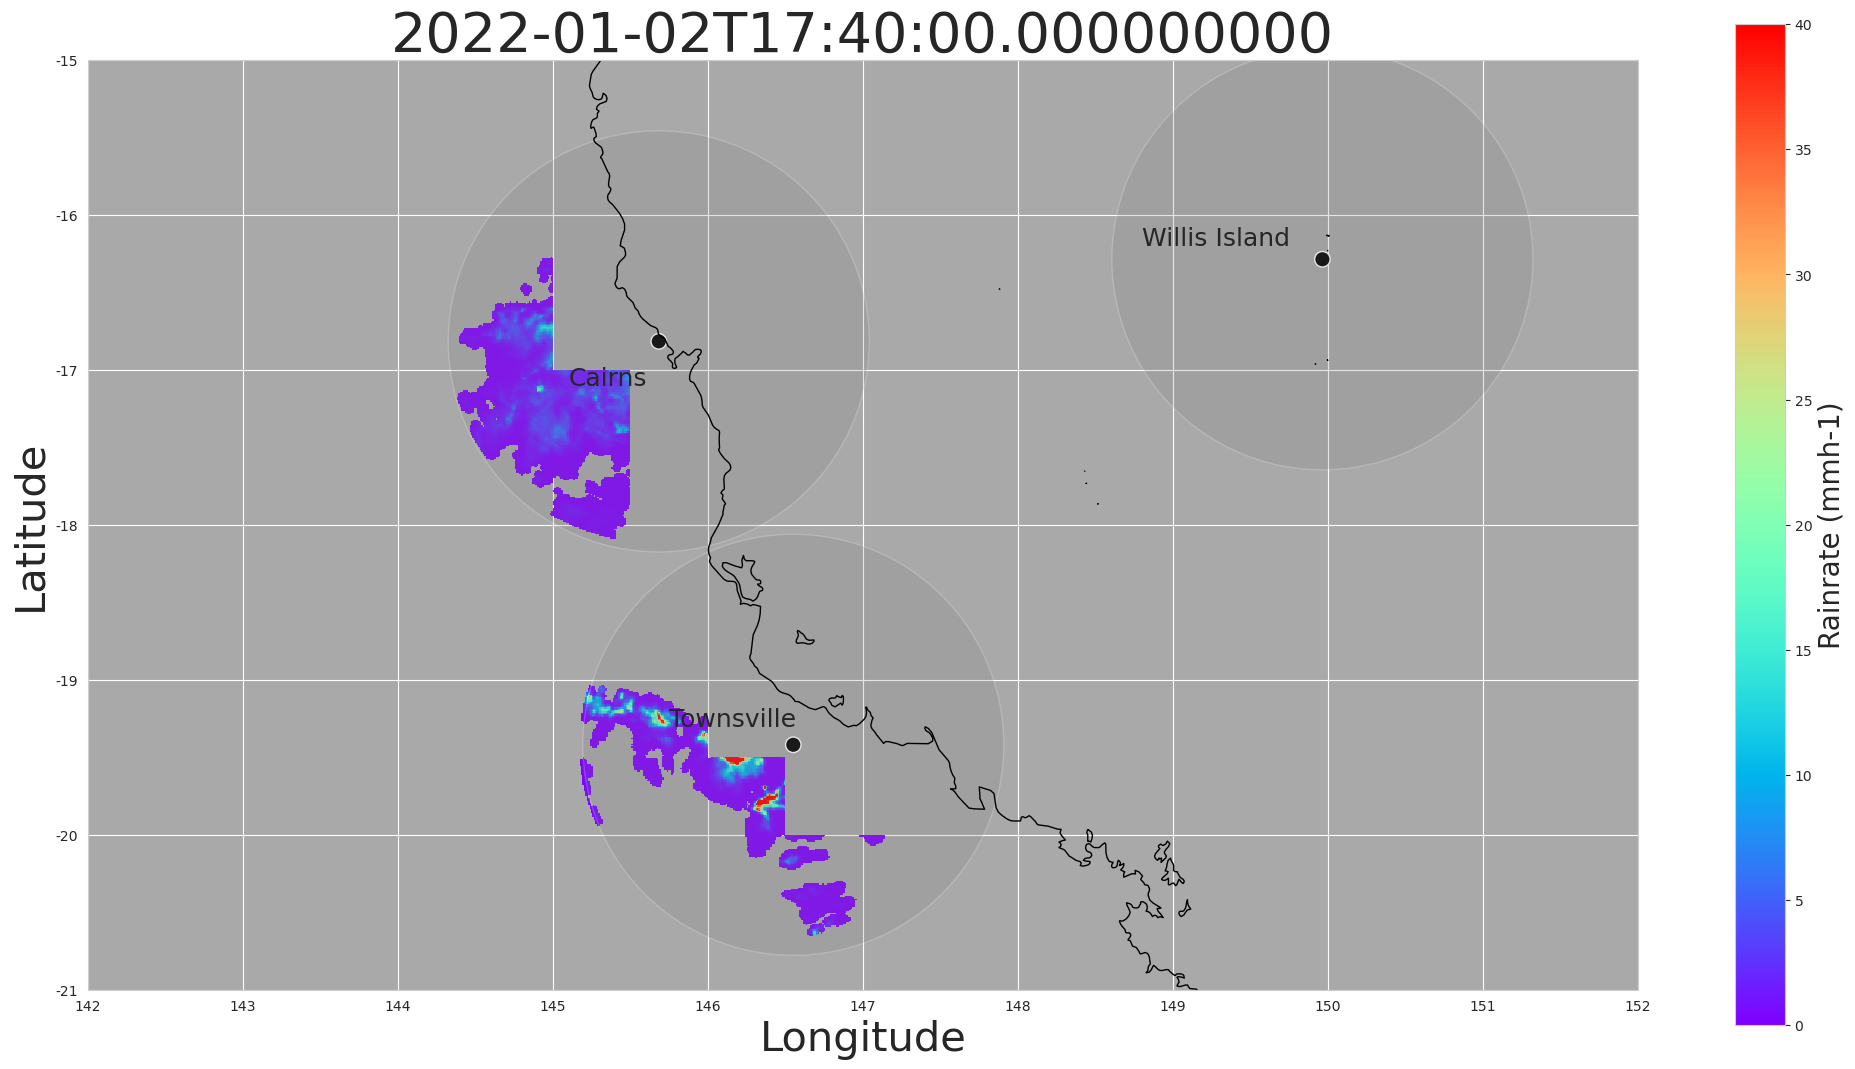

In [93]:
lon_T = ds_T.longitude.isel(time=0)
lon_C = ds_C.longitude.isel(time=0)
lon_W = ds_W.longitude.isel(time=0)

lat_T = ds_T.latitude.isel(time=0)
lat_C = ds_C.latitude.isel(time=0)
lat_W = ds_W.latitude.isel(time=0)

rr = ds_T.rainrate.units

#T = ((ds_T.longitude<145.75)&(ds_T.latitude>-19))+((ds_T.longitude<146)&(-19.5<ds_T.latitude<=-19))+((ds_T.longitude<146.5)&(-20<ds_T.latitude<=-19.5))+((ds_T.longitude<148)&(ds_T.latitude<=-20))

mask_T = ds_T.rainrate.where(((ds_T.longitude<146)&(ds_T.latitude>-19.5))+((ds_T.longitude<146.5)&(ds_T.latitude>-20)&(ds_T.latitude<=-19.5))+((ds_T.longitude<148)&(ds_T.latitude<=-20))).isel(time=400)
mask_C = ds_C.rainrate.where(((ds_C.longitude<145)&(ds_C.latitude>-17))+((ds_C.longitude<145.5)&(ds_C.latitude<=-17))).isel(time=500)
mask_W = ds_W.rainrate.isel(time=400)

radar_field(lon_T,lon_C,lon_W,lat_T,lat_C,lat_W,mask_T,
            mask_C,mask_W,
           "rainbow",rr,ds_T.time[500].values) #,ds_T.time[0].values)#"Corrected Reflectivity at 2.5km: 14/02/2022")

In [59]:
# horizontal axes (hour) - 24hours - data specifies points on x-axis
time_T = ds_T.time.groupby("time.hour")
time_array_T = []
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
    time_TT = time_T[i].values
    time_array_T.append(time_TT)
x = time_array_T
# vertical data is rainrate value - data specifies points on y-axis
y = np.arange(0,24,1)
# data is rr mean per hour
radar_rr_T = ds_T.rainrate.isel(y=150,x=slice(0,150)) # x slice should be modified to be a little longer to cover all land area 
rr_data = []
for j in time_array_T:
    r = radar_rr_T.values
    rr_data.append(r)
data = rr_data
data_T =  rr_data>0

SyntaxError: invalid syntax (1983567295.py, line 17)

In [58]:
#sns.lineplot(data=data,x=x,y=y)

24